#  <center><h2>单应性变换</h2></center>

# 一、人工特征点匹配实现单应性变换

## 1、利用鼠标事件获取的四对匹配点坐标

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

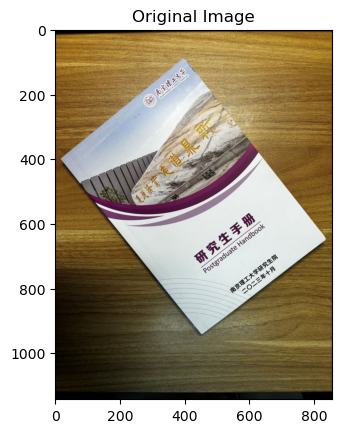

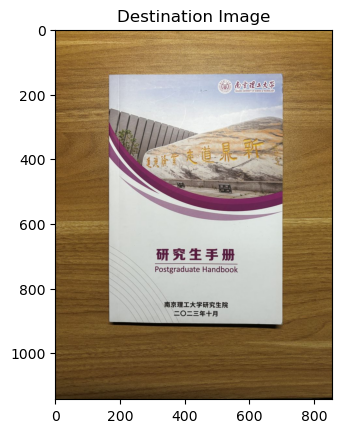

(<matplotlib.image.AxesImage at 0x1f5f56435e0>, None)

In [14]:
# 读入图片
img1 = cv2.imread('./img/input/1.jpg')
img2 = cv2.imread('./img/input/2.jpg')

plt.title("Original Image")
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)), plt.show()
plt.title("Destination Image")
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)), plt.show()

In [11]:
# 读取图片
img1 = cv2.imread('./img/input/1.jpg')

# 显示图片
cv2.imshow('image', img1)
# 查看图片中某个点的坐标
def on_mouse(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        print(f'x: {x}, y: {y}')

cv2.setMouseCallback('image', on_mouse)

# 等待按下任意按键
cv2.waitKey(0)

# 关闭所有窗口
cv2.destroyAllWindows()

x: 19, y: 400
x: 397, y: 90
x: 837, y: 648
x: 453, y: 945


In [12]:
img2 = cv2.imread('./img/input/2.jpg')
# 显示图片
cv2.imshow('image', img2)
# 查看图片中某个点的坐标
def on_mouse(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        print(f'x: {x}, y: {y}')

cv2.setMouseCallback('image', on_mouse)

# 等待按下任意按键
cv2.waitKey(0)

# 关闭所有窗口
cv2.destroyAllWindows()

x: 167, y: 142
x: 701, y: 139
x: 701, y: 912
x: 167, y: 905


## 2、计算单应性矩阵

In [15]:
def get_homography_matrix(source, destination):
    """ Calculates the entries of the Homography matrix between two sets of matching points.
    Args
    ----
        - `source`: Source points where each point is int (x, y) format.
        - `destination`: Destination points where each point is int (x, y) format.
    Returns
    ----
        - A numpy array of shape (3, 3) representing the Homography matrix.
    Raises
    ----
        - `source` and `destination` is lew than four points.
        - `source` and `destination` is of different size.
    """
    assert len(source) >= 4, "must provide more than 4 source points"
    assert len(destination) >= 4, "must provide more than 4 destination points"
    assert len(source) == len(destination), "source and destination must be of equal length"
    A = []
    b = []
    for i in range(len(source)):
        s_x, s_y = source[i]
        d_x, d_y = destination[i]
        A.append([s_x, s_y, 1, 0, 0, 0, (-d_x)*(s_x), (-d_x)*(s_y)])
        A.append([0, 0, 0, s_x, s_y, 1, (-d_y)*(s_x), (-d_y)*(s_y)])
        b += [d_x, d_y]
#         b += [0, 0]
    A = np.array(A)
    h = np.linalg.lstsq(A, b)[0]
    h = np.concatenate((h, [1]), axis=-1)
    return np.reshape(h, (3, 3))

In [16]:
# 匹配点坐标集
src_points = np.array([[19, 400], [397, 90], [837, 648], [453, 945]])
dst_points = np.array([[167, 142], [701, 139], [701, 912], [167, 905]])

# 计算单应性矩阵
H_self = get_homography_matrix(src_points, dst_points)
print(H_self)

# 调用库函数计算单应性矩阵
H, _ = cv2.findHomography(src_points, dst_points)
print(H)

[[ 8.55718469e-01 -6.83513827e-01  4.23080469e+02]
 [ 6.81267888e-01  8.37277705e-01 -2.06761941e+02]
 [ 4.69175117e-06 -1.61870972e-05  1.00000000e+00]]
[[ 8.55718469e-01 -6.83513826e-01  4.23080469e+02]
 [ 6.81267888e-01  8.37277705e-01 -2.06761941e+02]
 [ 4.69175116e-06 -1.61870972e-05  1.00000000e+00]]


<ipython-input-15-e8baf969a332>:28: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  h = np.linalg.lstsq(A, b)[0]


In [19]:
print('两矩阵的差：')
print(H_self-H)

两矩阵的差：
[[-3.55637741e-12 -1.17703625e-11  4.95305130e-09]
 [ 2.02073913e-11 -1.67619252e-11 -7.67681740e-09]
 [ 9.87479057e-15 -2.82330752e-14  0.00000000e+00]]


### 3、实现单应性变换

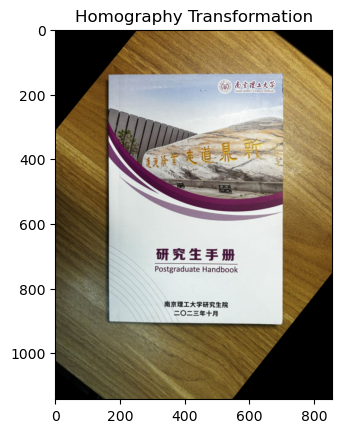

True

In [23]:
h, w = img1.shape[:2]
img1_warp = cv2.warpPerspective(img1, H_self, (w, h))
# 显示图片
homography = cv2.cvtColor(img1_warp, cv2.COLOR_BGR2RGB)
plt.title("Homography Transformation")
plt.imshow(homography), plt.show()
cv2.imwrite('./img/result/output1.png', img1_warp)

# 二、基于SIFT实现单应性变换

### a、检测关键点和计算关键点描述

In [24]:
def detectAndDescribe(image):
    # 转换为灰度图
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # 建立SIFT生成器
    descriptor = cv2.SIFT_create()
    # 检测特征点并计算描述子
    kps, features = descriptor.detectAndCompute(gray, None)
    kps = np.float32([kp.pt for kp in kps])
    return kps, features

In [25]:
# 读取图片
imageA = cv2.imread("./img/input/1.jpg")
imageB = cv2.imread("./img/input/2.jpg")
# 检测关键点和计算关键点描述
kpsA, featureA = detectAndDescribe(imageA)
kpsB, featureB = detectAndDescribe(imageB)
print('Kep points of Image1')
print(kpsA)
print('Kep points of Image2')
print(kpsB)

Kep points of Image1
[[  4.19482  703.783   ]
 [  4.677018 314.2865  ]
 [  5.581406 706.4601  ]
 ...
 [852.8654   531.2182  ]
 [854.19775  775.51587 ]
 [854.19775  775.51587 ]]
Kep points of Image2
[[  2.4797673 722.20355  ]
 [  3.004613  596.15204  ]
 [  3.520663  599.2046   ]
 ...
 [848.4426    560.8694   ]
 [849.9419    222.21677  ]
 [849.9419    222.21677  ]]


### b、匹配两张图片的特征点

In [26]:
def matchKeypoints(kpsA, kpsB, featureA, featureB, ratio, reprojThresh):
        # 建立暴力匹配器
        matcher = cv2.BFMatcher()

        # 使用KNN检测来自AB图的SIFT特征匹配
        rawMatches = matcher.knnMatch(featureA, featureB, 2)

        # 过滤
        matches = []
        for m in rawMatches:
            if len(m) == 2 and m[0].distance < m[1].distance * ratio:
                matches.append((m[0].trainIdx, m[0].queryIdx))

        if len(matches) > 4:
            # 获取匹配对的点坐标
            ptsA = np.float32([kpsA[i] for (_, i) in matches])
            ptsB = np.float32([kpsB[i] for (i, _) in matches])

            # 计算H矩阵
            H, status = cv2.findHomography(ptsA, ptsB, cv2.RANSAC, reprojThresh)

            return matches, H, status

# 绘制匹配结果
def drawMatches(imageA, imageB, kpsA, kpsB, matches, status):
    # 初始化可视化图片，将A、B图左右连接到一起
    hA, wA = imageA.shape[:2]
    hB, wB = imageB.shape[:2]
    vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
    vis[0:hA, 0:wA] = imageA
    vis[0:hB, wA:(wA+wB)] = imageB

    # 联合遍历，画出匹配对
    for ((trainIdx, queryIdx), s) in zip(matches, status):
        # 当点对匹配成功时，画到可视化图上
        if s == 1:
            # 画出匹配对
            ptA = (int(kpsA[queryIdx][0]), int(kpsA[queryIdx][1]))
            ptB = (int(kpsB[trainIdx][0]) + wA, int(kpsB[trainIdx][1]))
            cv2.line(vis, ptA, ptB, (0, 255, 0), 1)

    # 返回可视化结果
    return vis

[[ 8.48015604e-01 -6.83959575e-01  4.24659509e+02]
 [ 6.75964609e-01  8.30097533e-01 -2.04492701e+02]
 [ 6.09512779e-06 -2.83242499e-05  1.00000000e+00]]


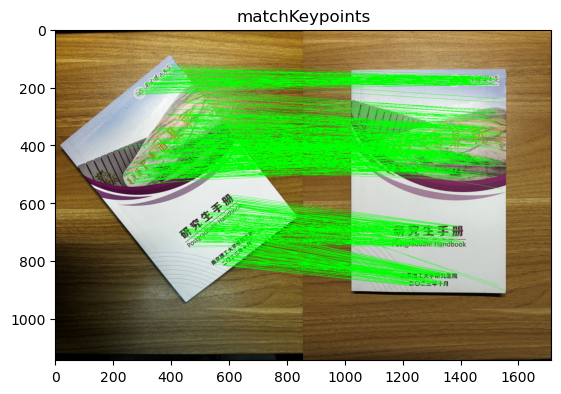

In [31]:
# 匹配两张图片的特征点
M = matchKeypoints(kpsA, kpsB, featureA, featureB, ratio = 0.75, reprojThresh = 4.0)
# 没有匹配点，退出
if not M:
    print('没有匹配点')
else:
    matches, H, status = M
    print(H)
    # 生成匹配图片
    matches = drawMatches(imageA, imageB, kpsA, kpsB, matches, status)
    vis = cv2.cvtColor(matches, cv2.COLOR_BGR2RGB)
    plt.title("matchKeypoints")
    plt.imshow(vis), plt.show()
    cv2.imwrite('./img/result/match.png', matches)

## 3、进行单应性变换

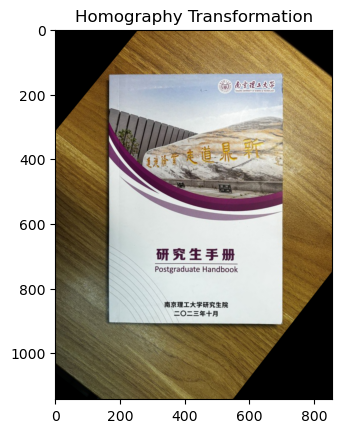

True

In [32]:
# 将图片A进行单应性变换 中间结果
result = cv2.warpPerspective(imageA, H, (imageA.shape[1], imageA.shape[0]))
homography = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
plt.title("Homography Transformation")
plt.imshow(homography), plt.show()
cv2.imwrite('./img/result/output2.png', result)